In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [4]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [5]:
# mjd, mag, mag_unc
# upper limits: mag = 5sigma, mag_unc = -999
X = np.loadtxt('SN2020jgb_ZTF_g_snr3.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr3.dat')

In [6]:
tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = (tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58969.470214999994 2.992744999999559


In [7]:
tp = 58986.41
z = 0.0307

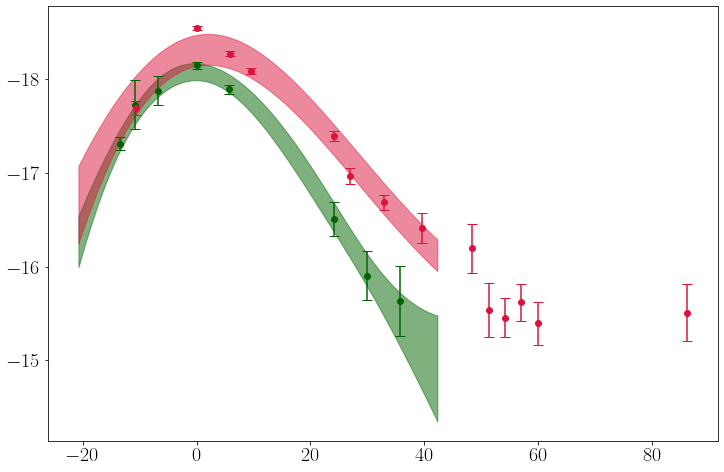

In [8]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(
    1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

tG = np.atleast_2d(X[X[:, 2] > 0, 0]).T
gmag = X[X[:, 2] > 0, 1]
gmag_unc = X[X[:, 2] > 0, 2]

tR = np.atleast_2d(Y[Y[:, 2] > 0, 0]).T
rmag = Y[Y[:, 2] > 0, 1]
rmag_unc = Y[Y[:, 2] > 0, 2]

gpG = GPR(kernel=kernel, alpha=gmag_unc**2, n_restarts_optimizer=10)
gpG.fit(tG, gmag)
gpR = GPR(kernel=kernel, alpha=rmag_unc**2, n_restarts_optimizer=30)
gpR.fit(tR, rmag)

tgp = np.linspace(58965, 59030, 100)
tgp = np.atleast_2d(tgp).T
gmag_pred, dgmag_pred = gpG.predict(tgp, return_std=1)
rmag_pred, drmag_pred = gpR.predict(tgp, return_std=1)

plt.figure(figsize=(12, 8))
plt.errorbar((tG.ravel() - tp) / (1 + z),
             gmag,
             yerr=gmag_unc,
             fmt='o',
             capsize=5,
             color='darkgreen')
plt.fill_between((tgp.ravel() - tp) / (1 + z),
                 gmag_pred.ravel() - dgmag_pred.ravel(),
                 gmag_pred.ravel() + dgmag_pred.ravel(),
                 color='darkgreen',
                 alpha=0.5)
plt.errorbar((tR.ravel() - tp) / (1 + z),
             rmag,
             yerr=rmag_unc,
             fmt='o',
             capsize=5,
             color='crimson')
plt.fill_between((tgp.ravel() - tp) / (1 + z),
                 rmag_pred.ravel() - drmag_pred.ravel(),
                 rmag_pred.ravel() + drmag_pred.ravel(),
                 color='crimson',
                 alpha=0.5)
plt.gca().invert_yaxis()

# Abi's models

## g, r

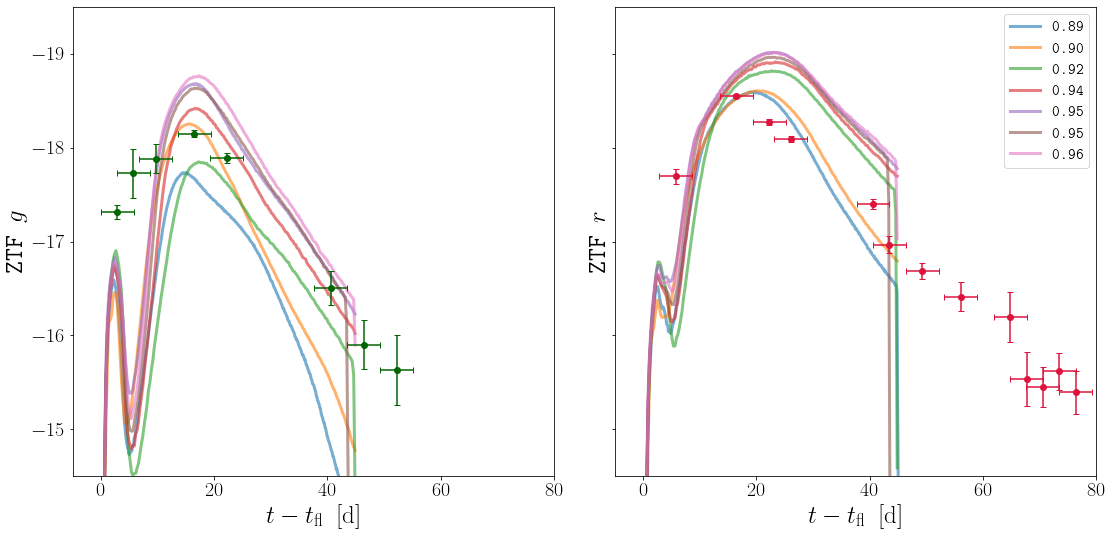

In [9]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mass = mod[pos + 5:][:mod[pos + 5:].find('_')]
    dat = np.loadtxt(mod)
    if (-19.5 < dat[:, 3].min() < -17.5) and (-19 < dat[:, 2].min() < -17):
        ax[0].plot(dat[:, 0], dat[:, 2], linewidth=3, alpha=0.6)  #g-band
        ax[1].plot(dat[:, 0], dat[:, 3], linewidth=3, label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar((tG.ravel() - tfl) / (1 + z),
               gmag,
               xerr=tfl_unc / (1 + z),
               yerr=gmag_unc,
               fmt='o',
               capsize=3,
               color='darkgreen')
ax[1].errorbar((tR.ravel() - tfl) / (1 + z),
               rmag,
               xerr=tfl_unc / (1 + z),
               yerr=rmag_unc,
               fmt='o',
               capsize=3,
               color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-14.5, -19.5)
ax[0].set_xlim(-5, 80)
ax[0].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[0].set_ylabel('ZTF $g$')
ax[1].set_ylabel('ZTF $r$')
plt.legend(loc=1, prop={'size': 15})
plt.tight_layout()
plt.show()

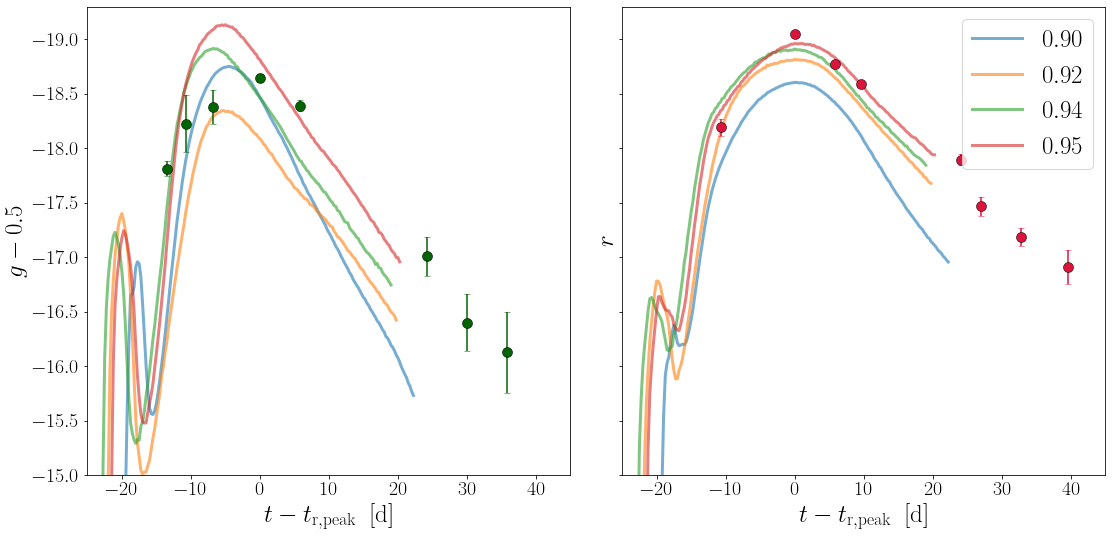

In [10]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mass = float(mod[pos + 5:][:mod[pos + 5:].find('_')])
    if mass == 0.89:
        continue
    mass = '${:.2f}$'.format(mass)
    dat = np.loadtxt(mod)
    if (-19.0 < dat[:, 3].min() < -17.0) and (-18.7 < dat[:, 2].min() < -16.7):
        ax[0].plot(dat[:-10, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:-10, 2] - .5,
                   linewidth=3,
                   alpha=0.6)  #g-band
        ax[1].plot(dat[:-10, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:-10, 3],
                   linewidth=3,
                   label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar(
    (tG.ravel() - tp) / (1 + z),
    gmag - .5,
    #xerr=2 / (1 + z),
    yerr=gmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color='darkgreen')
ax[1].errorbar(
    (tR.ravel() - tp) / (1 + z),
    rmag - .5,
    #xerr=2 / (1 + z),
    yerr=rmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-15, -19.3)
ax[0].set_xlim(-25, 45)
ax[0].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[0].set_ylabel('$g-0.5$')
ax[1].set_ylabel('$r$')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

## g-r

In [11]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/gr_adam.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [12]:
def mag1_mag2(X, Y, bin_size=1, intp=False):
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    unc1, unc2 = X[:, 2], Y[:, 2]
    if intp:
        t1, mag1, unc1 = interp(t1, mag1, unc1)
        t2, mag2, unc2 = interp(t2, mag2, unc2)
    #print(len(t1), len(mag1))
    i, j = 0, 0
    T = []
    dmag, Unc = [], []
    while i < len(t1):
        while j < len(t2):
            if t2[j] >= t1[i] + bin_size:
                i += 1
                continue
            if (np.abs(t2[j] - t1[i]) < bin_size):
                t = (t1[i] / unc1[i]**2 +
                     t2[j] / unc2[j]**2) / (1 / unc1[i]**2 + 1 / unc2[j]**2)
                mag = (mag1[i] - mag2[j])
                unc = (unc1[i]**2 + unc2[j]**2)**.5
                T = np.append(T, t)
                dmag = np.append(dmag, mag)
                Unc = np.append(Unc, unc)
                break
            j += 1
        i += 1
    arg = np.argwhere(Unc < 999).flatten()
    return T[arg], dmag[arg], Unc[arg]

In [13]:
gr_gp = gmag_pred - rmag_pred
gr_unc_gp = (dgmag_pred**2 + drmag_pred**2)**.5

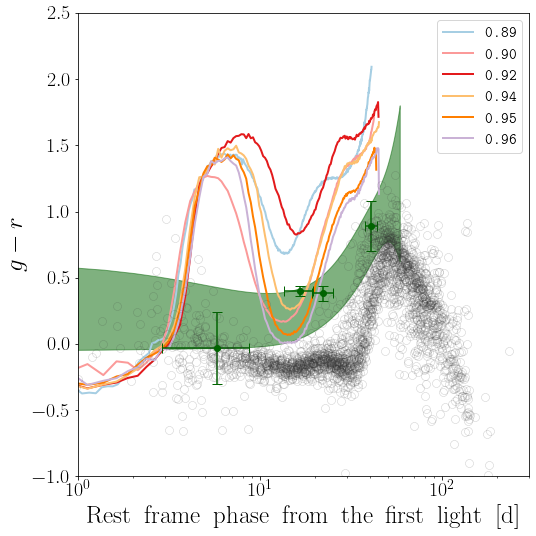

In [14]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

color = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
    '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a'
]

plt.figure(figsize=(8, 8))
num_model = -1
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    if '55' in mod:
        continue
    num_model += 1
    mass = mod[pos + 5:][:mod[pos + 5:].find('_')]
    dat = np.loadtxt(mod)
    dat = np.array([d for d in dat if np.prod(d) != 0])
    while dat[-1, 2] - dat[:, 2].min() > 3:
        dat = dat[:-1]
    if (-19.5 < dat[:, 3].min() < -17.5) and (-19 < dat[:, 2].min() < -17):
        plt.plot(dat[:, 0],
                 dat[:, 2] - dat[:, 3],
                 label=mass,
                 linewidth=2,
                 color=color[num_model])
dT, dmag, Unc = mag1_mag2(X, Y, bin_size=1)
plt.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='o',
             capsize=5,
             color='darkgreen')
tgp = tgp.ravel()
plt.fill_between((tgp - tfl) / (1 + z),
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color='darkgreen',
                 alpha=0.5)
plt.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.3)
plt.ylim(-1, 2.5)
plt.xlim(1, 300)
plt.ylabel('$g-r$')
plt.xlabel(
    '$\mathrm{Rest\ frame\ phase\ from\ the\ first\ light}\ [\mathrm{d}]$')
plt.legend(loc=1, prop={'size': 15})
plt.xscale('log')
plt.tight_layout()
plt.show()

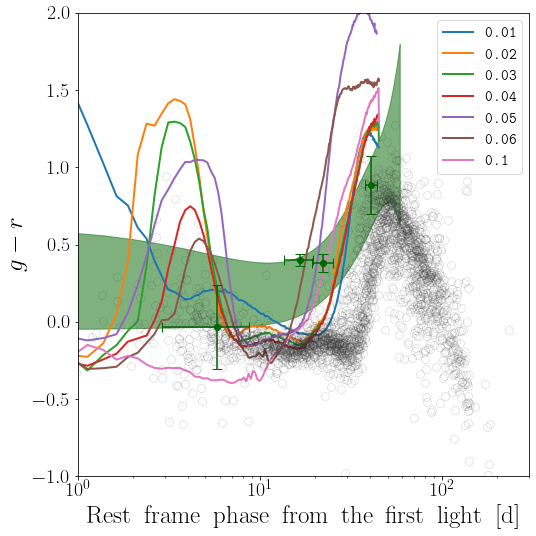

In [15]:
model = glob.glob('../../polin19_models/1.0WDs/*.mag')
model.sort()

plt.figure(figsize=(8, 8))
for mod in model:
    mass = mod[mod.find('1.0_') + 4:max(mod.find('_d'), mod.find('_e'))]
    dat = np.loadtxt(mod)
    dat = np.array([d for d in dat if np.prod(d) != 0])
    while dat[-1, 2] - dat[:, 2].min() > 3:
        dat = dat[:-1]
    if (-19.2 < dat[:, 3].min() < -17.5):
        plt.plot(dat[:, 0], dat[:, 2] - dat[:, 3], label=mass, linewidth=2)
dT, dmag, Unc = mag1_mag2(X, Y, bin_size=1)
plt.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='o',
             capsize=5,
             color='darkgreen')
plt.fill_between((tgp - tfl) / (1 + z),
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color='darkgreen',
                 alpha=0.5)
plt.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.3)
plt.ylim(-1, 2)
plt.xlim(1, 300)
plt.ylabel('$g-r$')
plt.xlabel(
    '$\mathrm{Rest\ frame\ phase\ from\ the\ first\ light}\ [\mathrm{d}]$')
plt.legend(loc=1, prop={'size': 15})
plt.xscale('log')
plt.tight_layout()
plt.show()

In [16]:
# 11fe
fe_lc = Table.read('11fe.csv')
fe_lc = fe_lc[~np.isnan(fe_lc['e_magnitude'])]
fe_lc['Phase'] = (fe_lc['time'] - 55816.6) / (1 + 0.0008)
fe_lc['Phase_fl'] = (fe_lc['time'] - 55796.687) / (1 + 0.0008)
fe_lc = fe_lc[~fe_lc['e_magnitude'].mask]

In [17]:
fe_g = fe_lc[fe_lc['band'] == 'g']
fe_r = fe_lc[fe_lc['band'] == 'r']

distmod = 29.04 #\pm 0.19

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.0077

fe_g['Mag'] = fe_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
fe_r['Mag'] = fe_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([fe_g['Phase'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase'], fe_r['Mag'], fe_r['e_magnitude']]).T
fe_g_bin = data_binning(X, size=0.5)
fe_r_bin = data_binning(Y, size=0.5)

X = np.array([fe_g['Phase_fl'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase_fl'], fe_r['Mag'], fe_r['e_magnitude']]).T
X = data_binning(X, size=0.5)
Y = data_binning(Y, size=0.5)
dT_fe, dmag_fe, Unc_fe = mag1_mag2(X, Y, bin_size=0.8)

In [18]:
# 18byg
byg_lc = Table.read('18byg.txt', format='ascii')
byg_lc = byg_lc[~np.isnan(byg_lc['e_omag'])]
byg_r = byg_lc[byg_lc['Filter'] == 'r']
byg_g = byg_lc[byg_lc['Filter'] == 'g']

In [19]:
z_byg = 0.066
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod0 = cosmo.distmod(z=z_byg)

beta1 = z_byg
beta2 = ((1 + z_byg)**2 - 1) / ((1 + z_byg)**2 + 1)

DL = np.loadtxt('18byg_peculiar.dat')[6]  #H0 = 70
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.011

byg_g['Mag'] = byg_g['omag'] - distmod.value - calALambda(leff_g, rv, ebv)
byg_r['Mag'] = byg_r['omag'] - distmod.value - calALambda(leff_r, rv, ebv)

In [20]:
color_byg = Table.read('color/gr_18byg.txt', format='ascii')
gr_byg = color_byg[color_byg['Filt'] == 'gr']
tfl_byg = 58233.198 + 9.07 / 2
tp_byg = byg_r['MJD'][np.argmin(byg_r['omag'])]
gr_byg['Phase'] = (gr_byg['Epoch'] + tp_byg - tfl_byg) / (1 + 0.066)
tp_byg

58260.2

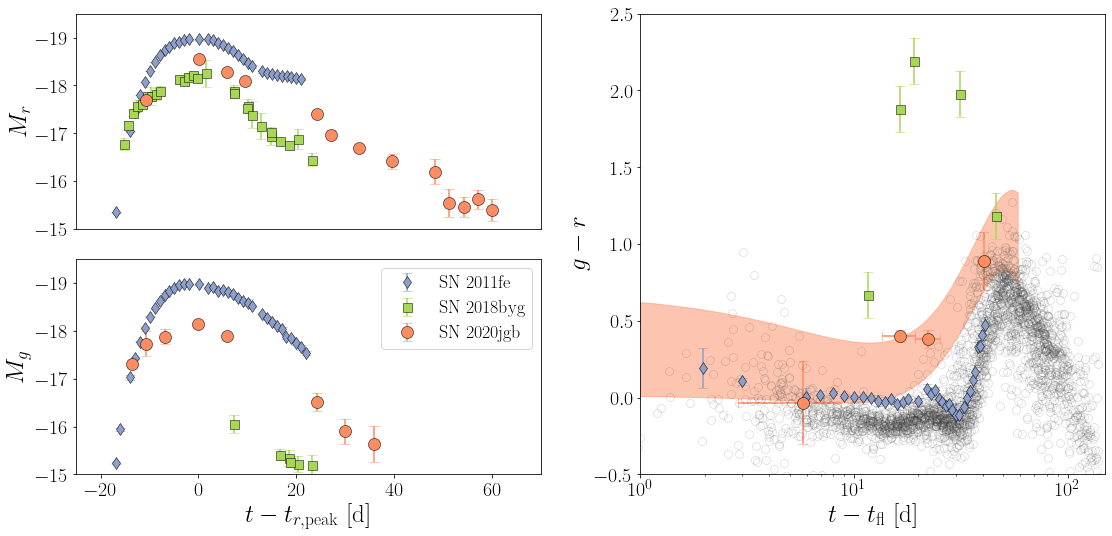

In [43]:
X = np.loadtxt('SN2020jgb_ZTF_g_snr3.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr3.dat')

X1 = np.loadtxt('SN2020jgb_ZTF_g_snr2.dat')
Y1 = np.loadtxt('SN2020jgb_ZTF_r_snr2.dat')

color_map = {
    'cyan': '#66c2a5',
    'orange': '#fc8d62',
    'blue': '#8da0cb',
    'purple': '#bebada',
    'pink': '#fccde5',
    'green': '#a6d854',
    'yellow': '#ffd92f',
    'brown': '#e5c494'
}

f = plt.figure(figsize=(16, 8))
ax2 = plt.subplot(2, 2, 1)
ax1 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

col_11fe = color_map['blue']
col_18byg = color_map['green']
col_20jgb = color_map['orange']

#11fe
ax1.errorbar(fe_g_bin[:, 0],
             fe_g_bin[:, 1],
             yerr=fe_g_bin[:, 2],
             fmt='d',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe,
             label='$\mathrm{SN\ 2011fe}$')
ax2.errorbar(fe_r_bin[:, 0],
             fe_r_bin[:, 1],
             yerr=fe_r_bin[:, 2],
             fmt='d',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)

#18 byg
ax1.errorbar(byg_g['Phase'],
             byg_g['Mag'],
             yerr=byg_g['e_omag'],
             fmt='s',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg,
             label='$\mathrm{SN\ 2018byg}$')
ax2.errorbar(byg_r['Phase'],
             byg_r['Mag'],
             yerr=byg_r['e_omag'],
             fmt='s',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)

Mag_pred, Mag_pred_unc = [], []
for x, x1, ax in zip([X, Y], [X1, Y1], [ax1, ax2]):
    t = x[x[:, 2] > 0, 0]
    mag = x[x[:, 2] > 0, 1].copy()
    mag_unc = x[x[:, 2] > 0, 2].copy()
    t_lim = x[x[:, 2] < 0, 0].copy()
    lim = x[x[:, 2] < 0, 1].copy()

    t1 = x1[x1[:, 2] > 0, 0]
    mag1 = x1[x1[:, 2] > 0, 1].copy()
    mag_unc1 = x1[x1[:, 2] > 0, 2].copy()

    ax.errorbar((t - tp) / (1 + z),
                mag,
                yerr=mag_unc,
                fmt='o',
                markersize=12,
                capsize=5,
                markeredgecolor='k',
                markeredgewidth=.5,
                color=col_20jgb,
                label='$\mathrm{SN\ 2020jgb}$')
    '''ax.scatter((t_lim - tp) / (1 + z),
                  lim,
                  s=50,
                  marker='v',
                  color=col,
                  alpha=0.5)'''
    kernel = 1 * RBF(length_scale=1.0,
                     length_scale_bounds=(1e-2, 1e3)) + .1 * WhiteKernel(
                         noise_level=1, noise_level_bounds=(1e-10, 1e1))

    gp = GPR(kernel=kernel, alpha=mag_unc1**2, n_restarts_optimizer=20)
    gp.fit(np.atleast_2d(t1).T, mag1)

    tgp = np.linspace(tfl, 59030, 100)
    mag_pred, dmag_pred = gp.predict(np.atleast_2d(tgp).T, return_std=1)
    Mag_pred.append(mag_pred)
    Mag_pred_unc.append(dmag_pred)
    '''ax.fill_between((tgp - tp) / (1 + z),
                       mag_pred - dmag_pred,
                       mag_pred + dmag_pred,
                       color=col,
                       alpha=0.2)'''

    ax.set_xlim(-25, 70)
    ax.set_ylim(-19.5, -15)

ax2.set_xticks([])
ax2.set_ylabel(r'$M_r$')
ax2.invert_yaxis()

ax1.legend(prop={'size': 18})
ax1.set_xlabel(r'$t-t_{r,\mathrm{peak}}\ [\mathrm{d}]$')
ax1.set_ylabel(r'$M_g$')
ax1.invert_yaxis()

gr_gp = Mag_pred[0] - Mag_pred[1]
gr_unc_gp = (Mag_pred_unc[0]**2 + Mag_pred_unc[1]**2)**.5

ax3.errorbar(dT_fe,
             dmag_fe,
             yerr=Unc_fe,
             fmt='d',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)
ax3.errorbar(gr_byg['Phase'],
             gr_byg['Color'],
             yerr=gr_byg['Err'],
             fmt='s',
             markersize=9,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)
ax3.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='o',
             markersize=12,
             capsize=5,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_20jgb)
ax3.fill_between((tgp - tfl) / (1 + z),
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color=col_20jgb,
                 alpha=0.5)
ax3.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.3)
ax3.set_ylim(-0.5, 2.5)
ax3.set_xlim(1, 150)
ax3.set_ylabel('$g-r$')
ax3.set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax3.set_xscale('log')
plt.tight_layout()
plt.savefig('../paper/figures/photometry.pdf', bbox_inches='tight')